<a href="https://colab.research.google.com/github/chesnokkk/traffic-sign-dataset-classification/blob/main/sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

# Новый раздел

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/datasets/Sings_detect/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

 94% 178M/190M [00:02<00:00, 92.9MB/s]
100% 190M/190M [00:02<00:00, 70.2MB/s]


In [ ]:
cd /content/drive/MyDrive/datasets/Sings_detect

/content/drive/MyDrive/datasets/Sings_detect


In [ ]:
!unzip traffic-sign-dataset-classification.zip

Archive:  traffic-sign-dataset-classification.zip
replace DATA/0/000_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace DATA/0/000_0002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: an
error:  invalid response [an]
replace DATA/0/000_0002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace DATA/0/000_0002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf

TEST_SIZE=0.1
SEED=42
BATCH_SIZE=64

tf.random.set_seed(SEED)


## Create pandas version of representation

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/datasets/Sings_detect/labels.csv')
print(labels_df.sample(10))

#Create a label map
label_map = dict(labels_df.values)
print(label_map)

    ClassId                                 Name
29       29                    Bicycles crossing
22       22                           Bumpy road
1         1                 Speed limit (30km/h)
15       15                          No vechiles
8         8                Speed limit (120km/h)
13       13                                Yield
17       17                             No entry
5         5                 Speed limit (80km/h)
14       14                                 Stop
32       32  End of all speed and passing limits
{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vechiles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vechiles', 16: 'Vechiles over 3.5 metric

In [ ]:
image_list = list(Path('/content/drive/MyDrive/datasets/Sings_detect/DATA').glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_list))

In [ ]:
#Create dataframe with path of images and labels
image_series = pd.Series(image_list).astype(str)
labels_series = pd.Series(labels).astype(str)
frame = {'image':image_series, 'label':labels_series}
image_df = pd.DataFrame(frame)

image_df.sample(5)

,image,label
633,/content/drive/MyDrive/datasets/Sings_detect/D...,15
2679,/content/drive/MyDrive/datasets/Sings_detect/D...,4
1112,/content/drive/MyDrive/datasets/Sings_detect/D...,24
495,/content/drive/MyDrive/datasets/Sings_detect/D...,13
3922,/content/drive/MyDrive/datasets/Sings_detect/D...,56


In [ ]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4170 non-null   object
 1   label   4170 non-null   object
dtypes: object(2)
memory usage: 65.3+ KB


In [ ]:
count_labels = image_df.groupby(['label']).size()

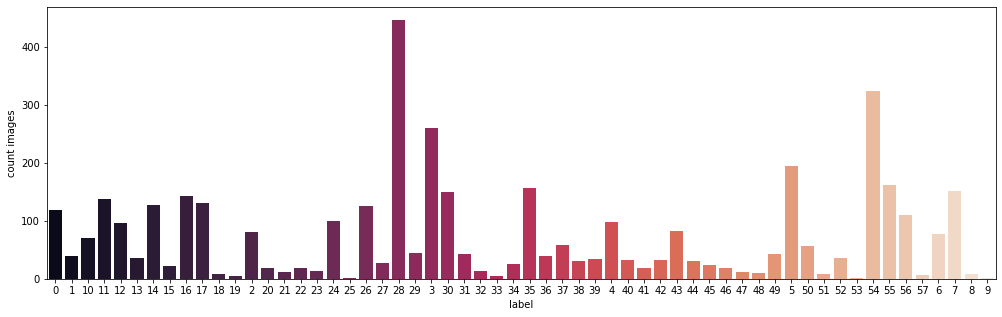

In [ ]:
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels, palette="rocket")


  Some labels contain very few image instances. If you apply random partitioning to training and validation, there is a chance that the training set will not reflect the entire general population. Let's split into training and validation only for the part where the number of image instances is higher than SPLIT_MINIMUM_COUNT_RATE

In [ ]:
SPLIT_MINIMUM_COUNT = 10

In [ ]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
  """
  Allocate a  dataset that has at least SPLIT_MINIMUM_COUNT_IMAGES of images
  
  split_df: dataframe for train
  train1_df: dataframe for drop
  """

  count_labels = df.groupby(['label']).size()
  count_labels_df = count_labels.to_frame(name='count_images').reset_index()

  drop_label_list = list(
      count_labels_df['label'].\
      loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
  )

  drop_df = df.copy()
  split_df = df.copy()

  for index, row in df.iterrows():
    if str(row.label) in drop_label_list:
      split_df = split_df.drop(index)
    else:
      drop_df = drop_df.drop(index)

  return split_df, drop_df

def custom_train_test_split(df):
    """
      Train test split where test_df has minimum 1 image in all labels
    in random split. This need to work model.fit and model.evaluate
    """
  
    labels = df.label.unique()
    test_df = pd.DataFrame()

    for label in labels:
      label_samples = df.loc[df.label==label]
      test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,
                               random_state=SEED))
    
    train_df = df.drop(list(test_df.index), axis=0)
    test_df = test_df.sample(frac=1, random_state=SEED)
    train_df = train_df.sample(frac=1, random_state=SEED)

    return train_df, test_df


In [ ]:
split_df, _ = split_dataset(image_df)

In [ ]:
train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)

In [ ]:
train_labels = train_df.groupby(['label']).size()
NUM_CLASSES = len(train_labels)

For training model, we need same labels in train and validation set

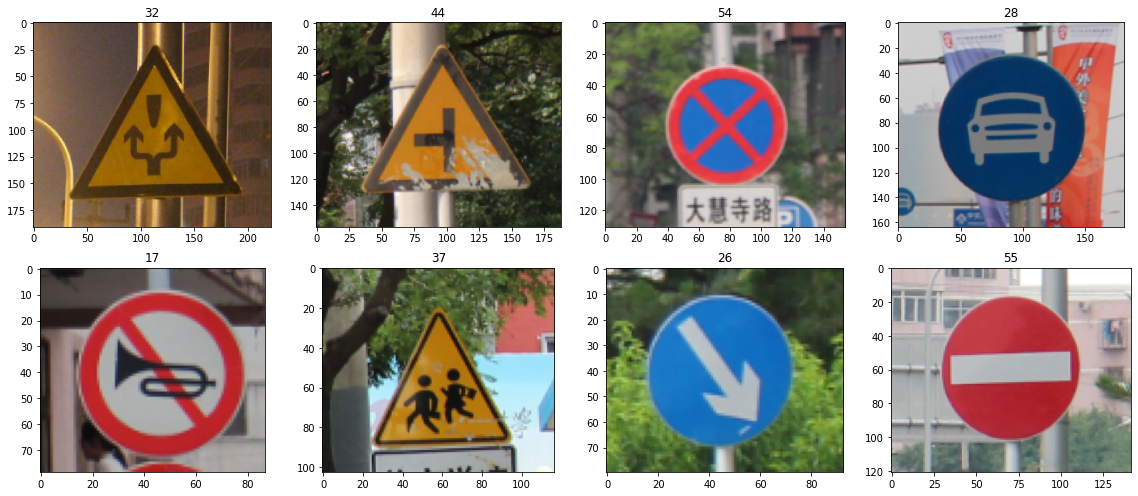

In [ ]:
#plot images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.image.iloc[idx]))
    ax.set_title(train_df.label.iloc[idx])
plt.tight_layout()
plt.show()

Parth 2. Train model

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant',
    shear_range=0.1,
    zoom_range=0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_images = test_generator.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
)



Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [ ]:
#create model
def create_model(input_shape=(128,128,3)):
  """
  load EfficientNet without last layer and 
  add Dense and ouput Dense with NUM_CLASSES units

  """
  inputs = tf.keras.layers.Input(input_shape)

  base_model = tf.keras.applications.EfficientNetB0(
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )
  base_model.trainable = False
  
  x = base_model(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  #x = tf.keras.layers.Dense(256, activation='relu')(x)
  outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return tf.keras.models.Model(inputs, outputs)

In [ ]:
model = create_model()

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_images,
    epochs=40,
    validation_data=val_images,
    callbacks=[callback]
)

Epoch 1/40
58/58 [==============================] - 605s 10s/step - loss: 0.9480 - acc: 0.7475 - val_loss: 0.9476 - val_acc: 0.8561
Epoch 2/40
58/58 [==============================] - 29s 492ms/step - loss: 0.2479 - acc: 0.9185 - val_loss: 0.5447 - val_acc: 0.8990
Epoch 3/40
58/58 [==============================] - 29s 496ms/step - loss: 0.1634 - acc: 0.9490 - val_loss: 0.3041 - val_acc: 0.9394
Epoch 4/40
58/58 [==============================] - 29s 492ms/step - loss: 0.1270 - acc: 0.9617 - val_loss: 0.2100 - val_acc: 0.9394
Epoch 5/40
58/58 [==============================] - 29s 497ms/step - loss: 0.0975 - acc: 0.9680 - val_loss: 0.1365 - val_acc: 0.9596
Epoch 6/40
58/58 [==============================] - 29s 494ms/step - loss: 0.1066 - acc: 0.9642 - val_loss: 0.1039 - val_acc: 0.9747
Epoch 7/40
58/58 [==============================] - 29s 500ms/step - loss: 0.0960 - acc: 0.9658 - val_loss: 0.0921 - val_acc: 0.9747
Epoch 8/40
58/58 [==============================] - 29s 500ms/step - l

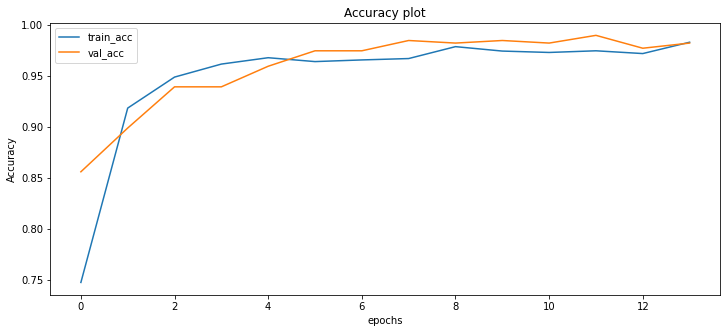

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Accuracy plot')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = np.argmax(model.predict(test_images),axis=1)

In [ ]:
score, accuracy = model.evaluate(test_images)

7/7 [==============================] - 2s 227ms/step - loss: 0.0538 - acc: 0.9819


In [ ]:
print(f'Test score: {round(score,4)}, Test accuracy: {round(accuracy,4)}')

Test score: 0.0538, Test accuracy: 0.9819
